In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# Import the Data

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
df.head(5)

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Searching for missing values

In [6]:
df.columns[df.isnull().sum()!=0]

Index(['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'electrical', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence',
       'miscfeature'],
      dtype='object')

There are many variables with apparent null values.  Next I want to search for missing values that may not be apparent

In [7]:
nulls = df.columns[df.isnull().sum()!=0]
cols = df.select_dtypes('object')
for col in cols:
    if col not in nulls:
        print(col,": ",df[col].unique())

mszoning :  ['RL' 'RM' 'C (all)' 'FV' 'RH']
street :  ['Pave' 'Grvl']
lotshape :  ['Reg' 'IR1' 'IR2' 'IR3']
landcontour :  ['Lvl' 'Bnk' 'Low' 'HLS']
utilities :  ['AllPub' 'NoSeWa']
lotconfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
landslope :  ['Gtl' 'Mod' 'Sev']
neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
bldgtype :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
housestyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
roofstyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
roofmatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
exterior1st :  [

now checking to see if any numeric values have a minimum as 0 as this could be a missing value

In [8]:
cols = df.select_dtypes(exclude='object')
for col in cols:
    if col not in nulls:
        print(col,": ",df[col].min())

id :  1
mssubclass :  20
lotarea :  1300
overallqual :  1
overallcond :  1
yearbuilt :  1872
yearremodadd :  1950
bsmtfinsf1 :  0
bsmtfinsf2 :  0
bsmtunfsf :  0
totalbsmtsf :  0
firstflrsf :  334
secondflrsf :  0
lowqualfinsf :  0
grlivarea :  334
bsmtfullbath :  0
bsmthalfbath :  0
fullbath :  0
halfbath :  0
bedroomabvgr :  0
kitchenabvgr :  0
totrmsabvgrd :  2
fireplaces :  0
garagecars :  0
garagearea :  0
wooddecksf :  0
openporchsf :  0
enclosedporch :  0
threessnporch :  0
screenporch :  0
poolarea :  0
miscval :  0
mosold :  1
yrsold :  2006
saleprice :  34900


As these have to do with counts and area, I'm assuming 0 is acceptable.  If I had more time I would look more into each

In [9]:
for null in nulls:
    print(null, ": ", df[null].isnull().sum())

lotfrontage :  259
alley :  1369
masvnrtype :  8
masvnrarea :  8
bsmtqual :  37
bsmtcond :  37
bsmtexposure :  38
bsmtfintype1 :  37
bsmtfintype2 :  38
electrical :  1
fireplacequ :  690
garagetype :  81
garageyrblt :  81
garagefinish :  81
garagequal :  81
garagecond :  81
poolqc :  1453
fence :  1179
miscfeature :  1406


In [10]:
(df.isnull().sum(axis=1).max())/df.shape[1]

0.18518518518518517

The greatest percentage of missing values in 1 row is about 19%.  If 20% of the data was missing, I would drop that row.

In [11]:
categorical = df.select_dtypes('object')

In [23]:
categorical_nulls = [x for x in nulls if x in categorical]
categorical_nulls

['alley',
 'masvnrtype',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'electrical',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'poolqc',
 'fence',
 'miscfeature']

Above are the categorical columns with nulls.  As none is a possible value for many of these, such as fence, I will leave them as none.  However before I dummy this, maybe I should look at outliers

In [29]:
df.fillna('None', inplace=True)

In [31]:
# it is hard to determine if None is missing or None just means none

In [33]:
df2 = pd.get_dummies(df)

In [ ]:
# when looking for outliers, use df.  Or should I handle outliers before one hot encoding?

In [ ]:
# need also to see how to drop a row by indices not just row number
# drop only accepts index labels so that is good.

In [ ]:
# just playing with matplotlib

In [38]:
# use seaborn for this, so much better

<AxesSubplot:>

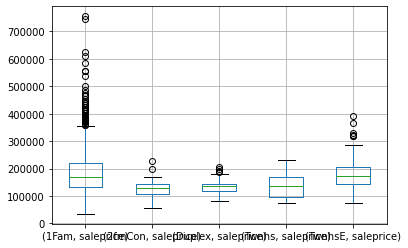

In [34]:
df[['bldgtype','saleprice']].groupby('bldgtype').boxplot(subplots=False)

<AxesSubplot:xlabel='bldgtype', ylabel='saleprice'>

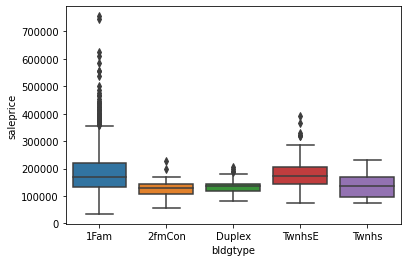

In [37]:
sns.boxplot('bldgtype','saleprice',data=df)